<a href="https://colab.research.google.com/github/miiiingi/dacon_housing/blob/main/dacon_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive/')
my_folder = '/gdrive/MyDrive/ColabNotebooks/dacon_housing/housing'

Mounted at /gdrive/


In [185]:
import pandas as pd
import numpy as np

In [217]:
trainset = pd.read_csv(f'{my_folder}/train.csv')
trainset = trainset.drop('id', axis = 1)

testset = pd.read_csv(f'{my_folder}/test.csv')
testset = testset.drop('id', axis = 1)

col_numerical = list(set(trainset.describe().columns))
col_categorical = list((set(trainset.columns) - set(col_numerical)))

kitchen qual 변수와 타겟변수와의 관계를 보니 kitchen qual에 따라서 타겟값의 변동성이 큰 것을 알 수 있다. 노이즈를 일으킬 수 있을 것 같아서 우선 kitchen qual 변수를 제거해보자.

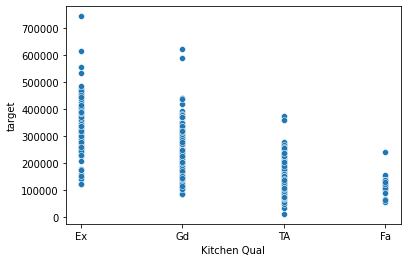

In [219]:
import seaborn as sns
sns.scatterplot(data = trainset, x ='Kitchen Qual', y = 'target')

In [220]:
trainset = trainset.drop('Kitchen Qual', axis = 1)
testset = testset.drop('Kitchen Qual', axis = 1)

결측치 확인하기 > 결측치가 존재하지 않음 \\
수치 > 평균 0 표준편차 1로 정규화 \\
범주형 > 원핫인코딩

In [221]:
for col in col_numerical : 
  if sum(trainset[col].isnull()) > 0 :
    print(f'{col} have a null values')
  if col == 'target' : 
    continue
    # mean_target = np.mean(trainset[col])
    # std_target = np.std(trainset[col])
  num_mean = np.mean(trainset[col])
  num_std = np.std(trainset[col])
  trainset[col] = (trainset[col] - num_mean) / num_std
trainset = pd.get_dummies(trainset)

우선 성능이 어느정도 나오는지 체크해보기 위해 제출해보기

In [222]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [237]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import lightgbm as lgbm
import xgboost as xgb
target_train = trainset['target']
data_train = trainset.drop('target', axis = 1)
scorer = make_scorer(NMAE)
reg = LinearRegression()
reg_rf = RandomForestRegressor()
reg_lgbm = lgbm.LGBMRegressor()
reg_xgb = xgb.XGBRegressor()
reg_ensemble = VotingRegressor([('linear', reg), ('rf', reg_rf), ('lgbm', reg_lgbm), ('xgb', reg_xgb)])
reg.fit(data_train, target_train)
reg_rf.fit(data_train, target_train)
reg_lgbm.fit(data_train, target_train)
reg_xgb.fit(data_train, target_train)
reg_ensemble.fit(data_train, target_train)

[08:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('linear', LinearRegression()),
                            ('rf', RandomForestRegressor()),
                            ('lgbm', LGBMRegressor()),
                            ('xgb', XGBRegressor())])

In [238]:
print(np.mean(cross_val_score(reg_rf, data_train, target_train, cv = 2, scoring= scorer)))
print(np.mean(cross_val_score(reg_lgbm, data_train, target_train, cv = 2, scoring= scorer)))
print(np.mean(cross_val_score(reg, data_train, target_train, cv = 2, scoring= scorer)))
print(np.mean(cross_val_score(reg_xgb, data_train, target_train, cv = 2, scoring= scorer)))
print(np.mean(cross_val_score(reg_ensemble, data_train, target_train, cv = 2, scoring= scorer)))

0.10125330074265464
0.10648056048506294
0.11164277251202864
[08:23:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.10031206337459507
[08:23:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.09770789431479524


In [239]:
col_numerical.remove('target')

In [240]:
for col in col_numerical : 
  if sum(testset[col].isnull()) > 0 :
    print(f'{col} have a null values')
  num_mean = np.mean(testset[col])
  num_std = np.std(testset[col])
  testset[col] = (testset[col] - num_mean) / num_std
testset = pd.get_dummies(testset)

In [244]:
prediction = reg_ensemble.predict(testset)
sample_submission = pd.read_csv(f'{my_folder}/sample_submission.csv')
answer = pd.DataFrame({'id' : sample_submission['id'], 'target' : prediction})
answer.to_csv(f"{my_folder}/submission.csv", index=False)

0.1116 > 0.1131 \\
0.09770789431479524 > 0.09762